In [1]:
import sys
sys.path.append("..")

import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt

import pyequion2
import tmcdiff.builder

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl", "Ca", "C"], from_elements=True, backend="jax", logbase="e")

In [4]:
eqsys.elements

['H', 'O', 'Ca', 'Cl', 'Na', 'C']

In [5]:
eqsysfront = pyequion2.EquilibriumSystem(["Na", "Cl", "Ca", "C"], from_elements=True)
balance = {'Na': 75.0, 'Cl':56.0, 'Ca':28.0, 'C':65.0}
eqsysfront.solve_equilibrium_mixed_balance(298.15, molal_balance=balance)

(<pyequion2.solution.SolutionResult at 0x7f852280b130>,
 {'res': array([ 3.92574862e-13,  3.53495011e-13, -1.77635684e-14,  2.12607709e-13,
         -2.73114864e-13,  6.45483667e-13,  5.68434189e-14, -7.99360578e-14,
          8.88178420e-15, -7.28306304e-14,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
  'x': array([4.28503689e-04, 4.03583577e-06, 5.07903025e-14, 3.77942506e-13,
         2.80000000e+01, 8.10546031e-24, 5.60000000e+01, 2.80236719e-03,
         2.53423142e+01, 5.33395199e+01, 1.00032268e+01, 1.85960298e-10,
         1.65402647e+00, 7.48547586e-13, 1.34525464e-11])})

In [6]:
{sp: k for sp, k in zip(eqsys.species, eqsys.get_standard_chemical_potentials(298.15))}

{'H2O': DeviceArray(-237172.17, dtype=float32),
 'CO2': DeviceArray(-385941.53, dtype=float32),
 'CO3--': DeviceArray(-527900., dtype=float32),
 'Ca++': DeviceArray(-553040., dtype=float32),
 'CaCO3': DeviceArray(-1099350., dtype=float32),
 'CaHCO3+': DeviceArray(-1146208.4, dtype=float32),
 'CaOH+': DeviceArray(-717263.8, dtype=float32),
 'Cl-': DeviceArray(-131260., dtype=float32),
 'H+': DeviceArray(0., dtype=float32),
 'HCO3-': DeviceArray(-586857.2, dtype=float32),
 'Na+': DeviceArray(-261890., dtype=float32),
 'Na2CO3': DeviceArray(-1055515.8, dtype=float32),
 'NaCO3-': DeviceArray(-797039.2, dtype=float32),
 'NaHCO3': DeviceArray(-847320.2, dtype=float32),
 'NaOH': DeviceArray(-418122.6, dtype=float32),
 'OH-': DeviceArray(-157290., dtype=float32)}

In [7]:
builder = tmcdiff.builder.FixedGridTransportBuilder(eqsys, 298.15, 0.1, 1e-6, jnp.array([65, 56, 75.0, 28.0, 0.0]), ["Calcite"])
builder.set_species(['CaCO3', 'CaHCO3+', 'CaOH+', 'Na2CO3', 'NaCO3-', 'NaHCO3', 'NaOH', 'CaOH+',
                     'H+', 'OH-'])
builder.make_grid(10, 5)
builder.set_initial_guess()
builder.species

['CO2', 'CO3--', 'Ca++', 'Cl-', 'HCO3-', 'Na+']

In [8]:
sol, sol_simple = builder.solve()

In [12]:
sol_simple

         cg_niter: 3825
     cg_stop_cond: 2
           constr: [array([ 8.0083399e+00,  2.5813468e-03, -6.5529114e-03,  1.4156707e-02,
       -3.5614025e-02,  4.9574368e-02, -4.2860061e-02,  1.8252923e-01,
       -2.5593693e+00, -5.0508694e+01, -1.6035589e-03, -4.2873179e-04,
        2.7600583e-03, -4.0367846e-03, -2.1263955e-02,  6.8720818e-02,
        4.6886131e-04, -8.7251055e-01, -7.1780524e+00, -2.7177315e+00,
       -1.4476073e-03,  3.1455816e-03, -2.3006946e-03,  8.2034385e-05,
       -5.9817475e-03,  1.6997937e-02,  1.1819288e-02, -2.0299335e+00,
       -5.0548983e+00, -1.6731838e+01, -1.3466357e-03, -3.8004732e-03,
        1.8686496e-02, -3.1810656e-02,  6.8273917e-02, -8.8398516e-02,
        8.6717241e-02, -5.8687299e-02, -4.0174274e+00, -1.9813366e+00,
        4.0041767e-03,  1.6298585e-02, -5.5550452e-02,  9.5995054e-02,
       -1.9259399e-01,  2.2428268e-01, -2.4740003e-01, -6.7549515e-01,
        5.2840328e-01,  7.6464272e+00,  2.6652527e-01, -6.2289429e-01,
       -7.25

In [113]:
c = np.exp(builder.logc)

Text(0.5, 0, '$y^+$')

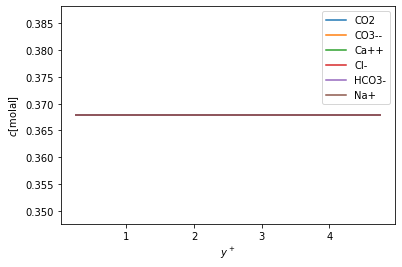

In [114]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [91]:
def f(cbulk):
    builder.cbulk = cbulk
    _, _ = builder.solve()
    dc = builder.fluxes()[:, -1:]
    dt = 1e-2
    return 4/dt*dc

In [56]:
f(jnp.array([65, 56, 75.0, 28.0, 0.0]))

DeviceArray([[-15.133566 ],
             [ -8.9779005],
             [ -1.6318988],
             [ -2.0280852],
             [-12.711183 ]], dtype=float32)

DeviceArray([[ 0,  0,  1,  0,  0,  0],
             [ 1,  1,  0,  0,  1,  0],
             [ 0,  0,  0,  1,  0,  0],
             [ 0,  0,  0,  0,  0,  1],
             [ 0, -2,  2, -1, -1,  1]], dtype=int32)